In [ ]:
# Introducción

### Describir con lo que trabajamos, enumerar objetivos y su importancia

#! Describir los objetivos (con lo que vamos a trabajar)

#? Ejemplo: (Objetivo principal) Saber predecir si una transacción es fraudulenta o no
#?                               ¿De qué depende que una transaccion sea fraudulenta?
#?                               Si la cantidad sacada es alta, ¿hay mayor probabilidad de que sea fraudulenta?
#?                               ¿A que hora es más probable que haya una transacción fraudulenta?
#? Hasta 5 objetivos


# Datos
##? Describir la fuente de información
##? Variables disponibles
##? Datos recopilados (base de conocimiento)
##! Como se han preparado (limpieza, transformación, creación de variables, etc)
## Dificultades


# Clasificación

## Que modelo es mas apropiado (arbol de decisión, clasificación bayesiana, etc)
## ¿Qué variables son las mas importantes? ¿Por qué? ¿Cómo se puede mejorar el modelo?
## Se tiene que escoger el mas adecuado (hay que probarlos todos)


# Agrupamiento
## Mejor modelo para agrupamiento (basado en prototipos, jerárquico, etc)
### Se tiene que escoger el mas adecuado (hay que probarlos todos)


# Conlusión
## Como se usan nuestros modelos para mejorar la empresa


# Material consultado
## Bibliografía




# Datos de la base de conocimiento

## Variables Time V1-V28 Amount Fraud
## Septiembre de 2013
## 2 dias (Maximo 172792 segundos)


# Preguntas profesor
# Cuando comienza el tiempo. (Si el segundo 0 => 00:00)

## Paso a tipo numércio

In [2]:
import pandas as pd

def encode_categorical_columns(data):
    """
    Codifica las columnas no numéricas de un DataFrame en números.

    Parámetros:
    data (DataFrame): El DataFrame que se va a transformar.

    Retorna:
    DataFrame: El DataFrame transformado.
    """
    for col in data.columns:
        if not pd.api.types.is_numeric_dtype(data[col]):
            mask = ~data[col].isna() # Máscara booleana para valores no NaN
            codes, _ = pd.factorize(data.loc[mask, col])
            data[data.columns[data.columns.get_loc(col)]] = pd.Series(codes, index=data.loc[mask, col].index)
            
    return data

In [46]:
credit_df = pd.read_csv('creditcard.csv')

#### No hay datos no numéricos ni faltantes

In [27]:
total_numeric = 0
for col in credit_df.columns:
    if not pd.api.types.is_numeric_dtype(credit_df[col]):
        total_numeric += 1

emptyRowsAttr = credit_df.isnull().sum(axis=1).value_counts()

print(f'Hay {total_numeric} columnas no numéricas')

print('Valores nulos de cada columna:')
print(credit_df.isna().sum()) # Verifica que no haya valores NaN

Hay 0 columnas no numéricas

Valores nulos de cada columna:

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Analizamos si la clase objetivo está desbalanceado mirando los valores totales que toman la columna de Class

In [28]:
print(credit_df['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64

#### Clase muy desbalanceada

In [47]:
FEATURES = credit_df.drop(['Class'], axis=1) # Features
TARGET = credit_df['Class']                  # Target

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42) # Crea un objeto SMOTE con semilla 42
X_sm, y_sm = smote.fit_resample(FEATURES, TARGET)

In [49]:
credit_df_resampled = pd.concat([pd.DataFrame(X_sm), pd.DataFrame(y_sm)], axis=1)
credit_df_resampled.columns = credit_df_resampled.columns
credit_df_resampled.to_csv('./data/datos_credit_balanced.csv', index=False)

In [50]:
print('Valores de la columna LoanStatus:')
credit_df_resampled['Class'].describe()

Valores de la columna LoanStatus:

count    568630.0
mean          0.5
std           0.5
min           0.0
25%           0.0
50%           0.5
75%           1.0
max           1.0
Name: Class, dtype: float64

#### Outliers

In [75]:
from matplotlib import pyplot as plt

# drop column Class and Time
credit_df_resampled_test = credit_df_resampled.drop(['Class', 'Time'], axis=1)

for columna in credit_df_resampled_test:
    plt.boxplot(credit_df_resampled[columna])
    plt.title(columna)
    plt.savefig(f'./outliers/plots/boxplot_{columna}.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [63]:
import numpy as np

for column in credit_df_resampled_test.columns:
    Q1 = credit_df_resampled_test[column].quantile(0.25)
    Q3 = credit_df_resampled_test[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = credit_df_resampled_test[(credit_df_resampled_test[column] < Q1 - 1.5*IQR) | (credit_df_resampled_test[column] > Q3 + 1.5*IQR)]    
    if len(outliers) > 0:
        txt_to_file = "--------------------------------------------------" + "\n"
        txt_to_file += "Columna: " + column + "\n"
        txt_to_file += "Outliers: " + str(len(outliers)) + "\n"
        with open("./outliers/outliers_IQR.txt", "a") as file:
            file.write(txt_to_file)


In [64]:
for column in credit_df_resampled_test.columns:
    media = np.mean(credit_df_resampled_test[column])
    desviacion_estandar = np.std(credit_df_resampled_test[column])
    umbral = 3 * desviacion_estandar
    outliers = credit_df_resampled_test[abs(credit_df_resampled_test[column] - media) > umbral]
    if len(outliers) > 0:
        str = f"Columna {column}: {len(outliers)} outliers" + "\n"
        with open("./outliers/outliers_3desviacion_estandar.txt", "a") as file:
            file.write(str)
        # print(f"Columna {column}: {len(outliers)} outliers")
        # print(f"Media: {media}")
        # print(f"Desviación estándar: {desviacion_estandar}")
        # print(f"Umbral para outliers: {umbral}")
        # print(f"Filas con  outliers:\n{outliers[column]}")

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
axs = axs.flatten()
for i, col in enumerate(credit_df_resampled_test.columns):
    axs[i].hist(credit_df_resampled_test[col], bins=29, orientation='vertical', alpha=0.5)
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Frequency')
plt.tight_layout()
plt.savefig('./outliers/freq_histogram.png')

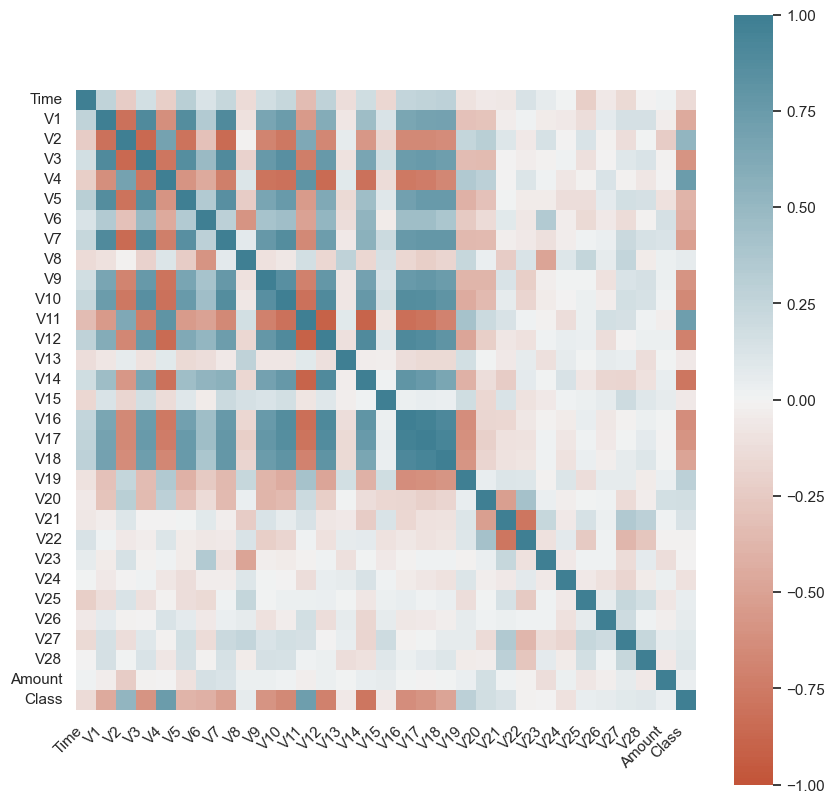

In [98]:
import seaborn as sns

data_corr = credit_df_resampled.corr()

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    data_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('./correlation_matrix.png')

In [99]:
for i in range(len(credit_df_resampled.columns)):
    for j in range(i):
        if abs(data_corr.iloc[i, j]) > 0.75:
            print(data_corr.columns[i], data_corr.columns[j], data_corr.iloc[i, j])

V2 V1 -0.8134411305584265

V3 V1 0.886639549368773

V3 V2 -0.8633758634499036

V4 V3 -0.7792748302553414

V5 V1 0.8741076704974353

V5 V2 -0.8028704744724056

V5 V3 0.8624781824658169

V7 V1 0.8864715968558373

V7 V2 -0.8580543043727

V7 V3 0.8917953243839568

V7 V5 0.8468794628408512

V9 V3 0.7628508152182933

V9 V4 -0.7962331947921516

V9 V7 0.7661551541569582

V10 V2 -0.7698146049482353

V10 V3 0.8549156080716929

V10 V4 -0.8190194378899567

V10 V5 0.7570501373017333

V10 V7 0.8691985590360575

V10 V9 0.8563521040018406

V11 V4 0.8190208706597599

V11 V10 -0.8166236038502246

V12 V3 0.7655623240293458

V12 V4 -0.8549724119863407

V12 V9 0.7812807506025654

V12 V10 0.8915353883540065

V12 V11 -0.9065661341077869

V14 V4 -0.8152126496235378

V14 V10 0.7697047751035196

V14 V11 -0.8949913677963571

V14 V12 0.8861262266682038

V16 V4 -0.7608921341404353

V16 V7 0.7649843392682657

V16 V9 0.7563762854191628

V16 V10 0.8681752313258415

V16 V11 -0.8236849109003611

V16 V12 0.9056954991970623

V16 V14 0.8001916327868929

V17 V3 0.7502683572778489

V17 V5 0.7515019353971466

V17 V7 0.7824632196649673

V17 V9 0.7838513636517342

V17 V10 0.8669330618336578

V17 V11 -0.7893042422013891

V17 V12 0.8813298872699891

V17 V14 0.7536053135089127

V17 V16 0.9541467364020152

V18 V5 0.7543663458315149

V18 V7 0.7773966853438429

V18 V10 0.8167234751978832

V18 V12 0.8061158992576205

V18 V16 0.9079466992333602

V18 V17 0.9408661422832246

V22 V21 -0.7748145782254142

Class V14 -0.7882445108732068